In [12]:
import dukit
import os
import matplotlib.pyplot as plt
import numpy as np
import logging

In [13]:
# this script assumes bunch of things in the default kwargs,
# e.g. that you want a div normalisation.

In [14]:
here = os.getcwd()
with open(
    os.path.dirname(here) + "/TEST_DATA_PATH.py", encoding="utf-8"
) as fid:
    exec(fid.read())  # reads in TEST_DATA_PATH string

In [15]:
# === SET PARAMS

DIR = TEST_DATA_PATH + "mz_test/"  # type: ignore
FILEPATH = DIR + "ODMR - Pulsed_10"
FIG_FORMAT = "png"

# ADDITIONAL_BINS = (4, 2) # asymmetric: (x, y)
ADDITIONAL_BINS = 4
ADDITIONAL_SMOOTH = 0  # can be asymmetric, but best not.

ROI_COORDS = (65, 65, 190, 190)  # start_x, start_y, ... for 4x binning
# ROI_COORDS = (-1, -1, -1, -1) # full ROI
AOI_COORDS = ((30, 40, 40, 45), (20, 20, 24, 24), (50, 50, 51, 51))
# AOI_COORDS = ((30, 40 , 40, 45),)

# to see how to create these see mz_draw_polys.py
POLY_PATH = FILEPATH + "_oldpolys.json"  # for 4x binning & ROI crop above
polygon_nodes = dukit.load_polygon_nodes(POLY_PATH)
ANNOTATE_POLYS = True

FIT_BACKEND = "cpufit"
FIT_MODEL = dukit.LinearLorentzians(2)
GUESSES = {"pos": [2720, 3020], "amp": -0.004, "fwhm": 20, "c": 1.0, "m": 0.0}
BOUNDS = {
    "pos_range": 30,
    "amp_range": 0.1,
    "fwhm_range": 50,
    "c_range": 0.1,
    "m_range": 0.01,
}

# === CREATE OUTPUT DIR & set mpl rcparams
OUTPUT_DIR = f"{FILEPATH}_output/"
try:
    os.mkdir(OUTPUT_DIR)
except FileExistsError:
    pass
dukit.mpl_set_run_config()
logging.info(dukit.__version__)
with open(OUTPUT_DIR + "dukit_version.txt", "w") as fid:
    fid.write(dukit.__version__)

FIT_RES_DIR = OUTPUT_DIR + "/data/"
# set below to "" or None or False to *not* load prev fit
PREV_FIT = ""  # FIT_RES_DIR[:]

In [16]:
# === READ IN DATA
sys = dukit.CryoWidefield()
sweep_arr = sys.read_sweep_arr(FILEPATH)
sig, ref, sig_norm = sys.read_image(FILEPATH)
raw_pixel_size = sys.get_raw_pixel_size(FILEPATH)

In [17]:
# === SMOOTH
if ADDITIONAL_SMOOTH:
    sig = dukit.smooth_image_stack(sig, ADDITIONAL_SMOOTH)
    ref = dukit.smooth_image_stack(ref, ADDITIONAL_SMOOTH)
    sig_norm = sys.norm(sig, ref)

# === REBIN & CROP
sig_rebinned = dukit.rebin_image_stack(sig, ADDITIONAL_BINS)
pl_img = dukit.sum_spatially(sig_rebinned)
sig = dukit.crop_roi(sig_rebinned, ROI_COORDS)
del sig_rebinned  # hacky but I want to keep the memory clear
ref = dukit.crop_roi(dukit.rebin_image_stack(ref, ADDITIONAL_BINS), ROI_COORDS)
sig_norm = dukit.crop_roi(
    dukit.rebin_image_stack(sig_norm, ADDITIONAL_BINS), ROI_COORDS
)
pl_img_crop = dukit.sum_spatially(sig)

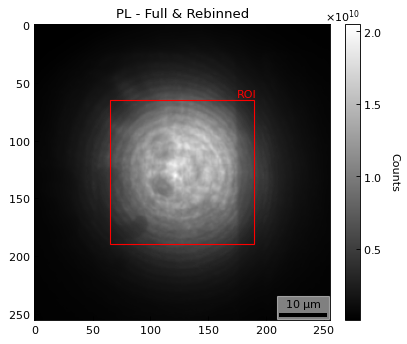

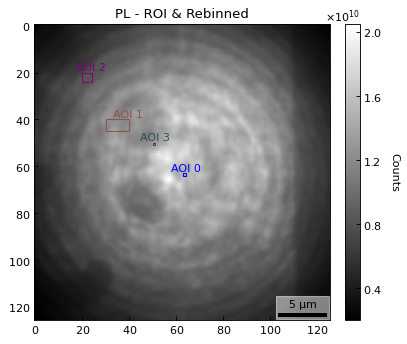

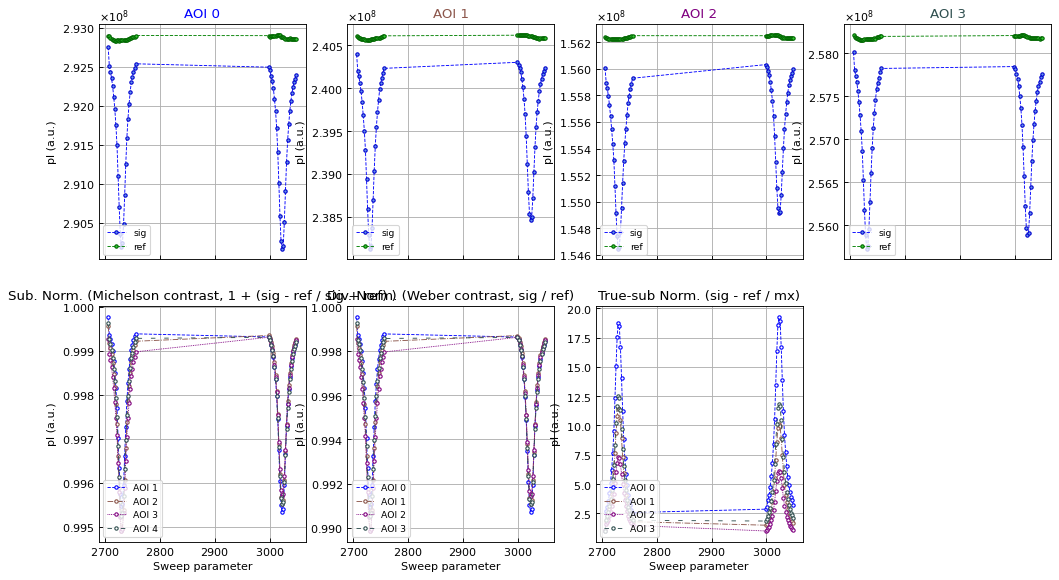

In [18]:
# === PLOT PL INFO
_ = dukit.plot.roi_pl_image(
    pl_img,
    ROI_COORDS,
    opath=OUTPUT_DIR + f"pl_full.{FIG_FORMAT}",
    show_tick_marks=True,
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
)
_ = dukit.plot.aoi_pl_image(
    pl_img_crop,
    *AOI_COORDS,
    opath=OUTPUT_DIR + f"pl_full.{FIG_FORMAT}",
    show_tick_marks=True,
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
)
_ = dukit.plot.aoi_spectra(
    sig,
    ref,
    sweep_arr,
    specpath=OUTPUT_DIR + "aoi_specta.json",
    opath=OUTPUT_DIR + f"aoi_spectra.{FIG_FORMAT}",
    *AOI_COORDS,
)

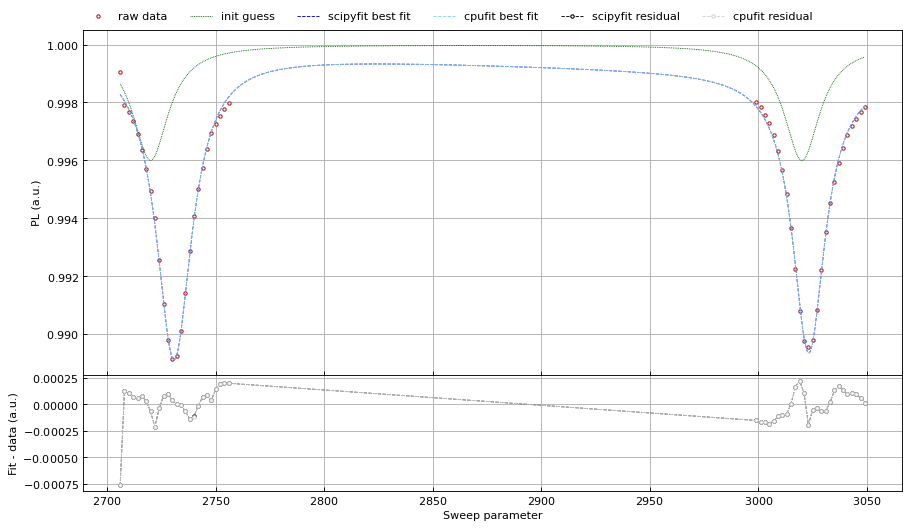

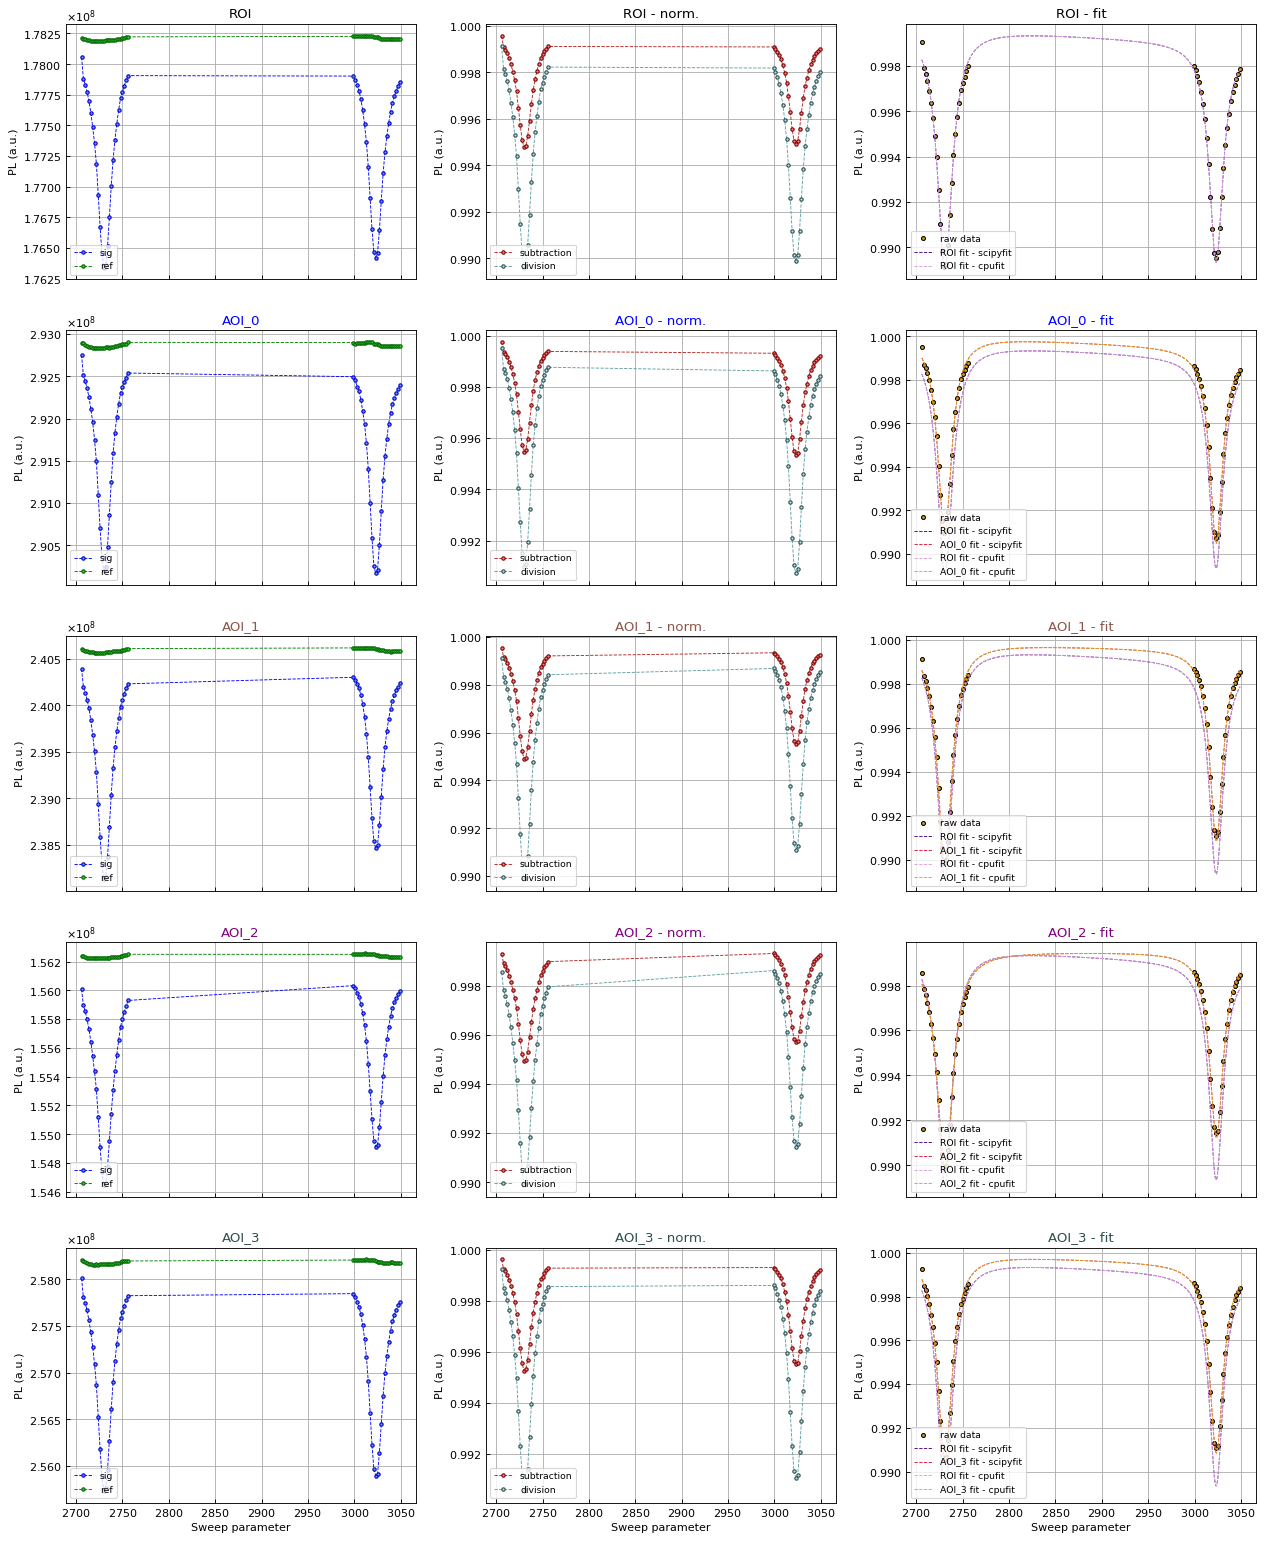

In [19]:
# fit_roi,  roi_avg_fits
roi_fit_results = dukit.fit_roi(
    sig,
    ref,
    sweep_arr,
    FIT_MODEL,
    GUESSES,
    BOUNDS,
    opath=OUTPUT_DIR + f"roi_avg_fit.json",
)
_ = dukit.plot.roi_avg_fits(
    roi_fit_results, opath=OUTPUT_DIR + f"roi_avg_fits.{FIG_FORMAT}"
)

# fit_aois, aoi_avg_fits
aoi_fit_results = dukit.fit_aois(
    sig,
    ref,
    sweep_arr,
    FIT_MODEL,
    GUESSES,
    BOUNDS,
    *AOI_COORDS,
    opath=OUTPUT_DIR + f"aoi_fits.json",
)
_ = dukit.plot.aoi_spectra_fit(
    aoi_fit_results,
    roi_fit_results,
    sig.shape[:-1],
    *AOI_COORDS,
    opath=OUTPUT_DIR + f"aoi_spectra_fit.{FIG_FORMAT}",
)


In [20]:
# fit_all_pixels_pl
if PREV_FIT:
    fit_image_results = dukit.load_fit_results(PREV_FIT, FIT_MODEL)
else:
    fit_image_results = dukit.fit_all_pixels(
        FIT_BACKEND,
        sig_norm,
        sweep_arr,
        FIT_MODEL,
        GUESSES,
        BOUNDS,
        roi_fit_results[FIT_BACKEND],
        odir=FIT_RES_DIR,
    )

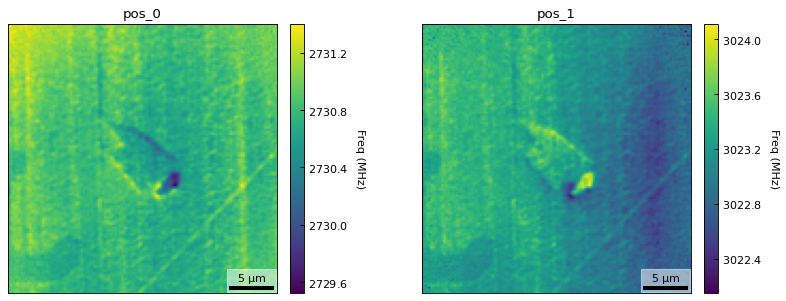

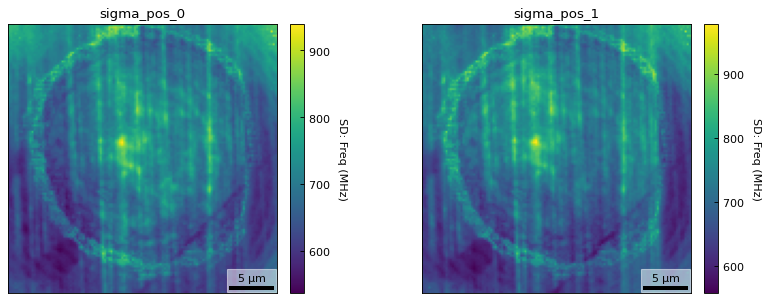

In [21]:
# pl_param_images
_ = dukit.plot.pl_param_images(
    FIT_MODEL,
    fit_image_results,
    "pos",
    opath=OUTPUT_DIR + f"pl_pos.{FIG_FORMAT}",
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
)

_ = dukit.plot.pl_param_images(
    FIT_MODEL,
    fit_image_results,
    "sigma_pos",
    opath=OUTPUT_DIR + f"sigma_pl_pos.{FIG_FORMAT}",
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
    errorplot=True,
)

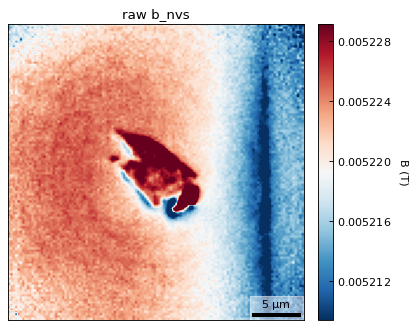

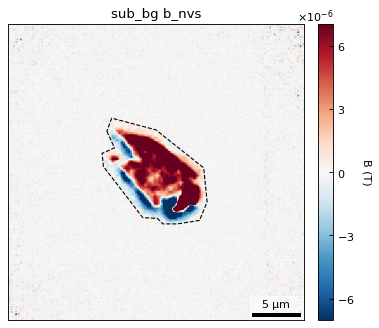

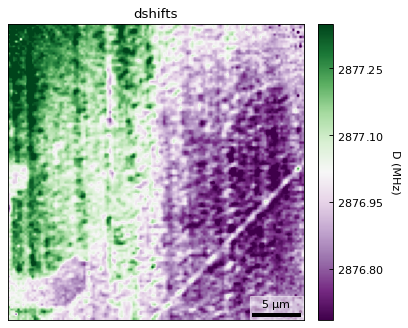

In [22]:
defect = dukit.NVEnsemble()
b_nvs = defect.b_defects((fit_image_results["pos_0"], fit_image_results["pos_1"]))
dshifts = defect.dshift_defects(
    (fit_image_results["pos_0"], fit_image_results["pos_1"])
)
# calc b_nv_bg, b_nv_sbg
# b_nv_bgs = tuple([dukit.get_background(bnv, "poly", order=2)[0] for bnv in b_nvs])
b_nv_bgs = tuple(
    [
        dukit.get_background(
            bnv,
            "interpolate",
            polygon_nodes=polygon_nodes,
            interp_method="linear",
            sigma=0.6,
        )[0]
        for bnv in b_nvs
    ]
)
b_nv_sbg = tuple([bnv - bnv_bg for bnv, bnv_bg in zip(b_nvs, b_nv_bgs)])
for i, b in enumerate(b_nv_sbg):
    np.savetxt(OUTPUT_DIR + f"/data/b_nv_sbg_{i}.txt", b)

_ = dukit.plot.b_defects(
    b_nvs,
    name="raw b_nvs",
    opath=OUTPUT_DIR + f"raw_b_nvs.{FIG_FORMAT}",
    c_range_type="percentile",
    c_range_values=(2, 98),
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
)
_ = dukit.plot.b_defects(
    b_nv_sbg,
    name="sub_bg b_nvs",
    opath=OUTPUT_DIR + f"b_nvs-sub_bg.{FIG_FORMAT}",
    c_range_type="percentile",
    c_range_values=(2, 98),
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
    annotate_polygons=ANNOTATE_POLYS,
    polygon_nodes=polygon_nodes,
)

_ = dukit.plot.dshifts(
    dshifts,
    name="dshifts",
    opath=OUTPUT_DIR + f"dshifts.{FIG_FORMAT}",
    c_range_type="percentile",
    c_range_values=(2, 98),
    raw_pixel_size=raw_pixel_size,
    applied_binning=ADDITIONAL_BINS,
)